<a href="https://colab.research.google.com/github/DimpleB0501/eva8/blob/main/Session5_normalization/backup/5_normalization_singlefile_removescheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Code


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
import random

### Data transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation(fill=(0,),degrees=(-7,7)), 
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

##### Dataset and creating test and train data

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Visualizing the dataset

### Dataloader arguments and test/ train dataloaders

In [4]:
SEED = 1
dropout_value = 0

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Model

In [5]:
from torch.nn.modules.batchnorm import BatchNorm2d
class Net(nn.Module):
    def __init__(self, normalization_type = "Batch", group_num = 0):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = self.convolution_layer (1, 8, 3, normalization_type, group_num)
        # CONVOLUTION BLOCK 
        self.convblock2 = self.convolution_layer (8, 24,  3, normalization_type, group_num)

        # TRANSITION BLOCK 
        self.transblock1 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=18, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
        ) # ip = 24 | op = 24 | RF = 
        self.pool1 = nn.MaxPool2d(2, 2) # ip = 24 | op = 12 | RF =

        # CONVOLUTION BLOCK 
        self.convblock3 = self.convolution_layer (18, 16,  3, normalization_type, group_num)
        

        # CONVOLUTION BLOCK 
        self.convblock4 = self.convolution_layer (16, 16,  3, normalization_type, group_num)
      

        # CONVOLUTION BLOCK
        self.convblock5 = self.convolution_layer (16, 16,  3, normalization_type, group_num)
        
        # GAP layer
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # ip = | op = | RF = 

        self.transblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # ip = 4 | op = 4 | RF = 

    def batchnormalization(self, output_channel_size, normalization_type = "Batch", group_num=0):
      if normalization_type == "Batch":
        return nn.BatchNorm2d(output_channel_size)
      elif normalization_type == "Layer": # https://pytorch.org/docs/stable/generated/torch.nn.GroupNorm.html
        return nn.GroupNorm(1, output_channel_size)
      elif normalization_type == "Group":
        return nn.GroupNorm(group_num, output_channel_size)

    def convolution_layer (self, input, output, kernel_val=3, normalization_type="Batch", group_num=0, dropout_val=0):
        layer = nn.Sequential(
                  nn.Conv2d(in_channels=input, out_channels=output, kernel_size=(kernel_val, kernel_val), padding=0, bias=False),
                  nn.ReLU(),
                  self.batchnormalization(output, normalization_type, group_num),
                  nn.Dropout(dropout_value)
                )  
        return layer


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.transblock1(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.gap(x)
        x = self.transblock2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Model parameters

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           1,728
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 18, 24, 24]             432
             ReLU-10           [-1, 18, 24, 24]               0
        MaxPool2d-11           [-1, 18, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           2,592

# Displaying misclassified images

In [7]:
def test_missclassified(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim = 1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data = data.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        model.eval()
        output = model(data)
        loss = F.nll_loss(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
    return true,pred,image,true_wrong,pred_wrong

In [8]:
# show misclassified images
def wrong_plot(n_figures,true,ima,pred, norm):
    print ("Normalization technique: ", norm)
    #n_row = int(n_figures/3)
    plt.figure(figsize = (20, 10))
    for r in range(n_figures):
      a = random.randint(0,len(true)-1)  
      image,correct,wrong = ima[a],true[a],pred[a]
      img_tensor = torch.from_numpy(image).unsqueeze(0).to(device)
      image = torch.from_numpy(image).squeeze()
      #correct = int(correct)
      #wrong = int(wrong)
      f = 'Actual:'+str(int(correct)) + ',' +'Predicted:'+str(int(wrong))
      image = image.numpy()
      
      plt.subplot(2,5,r+1)    # the number of images in the grid is 5*5 (25)
      im = plt.imshow(image)
      plt.title(f)
    plt.show()

### Training and testing

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, l_val, train_losses, train_acc):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # L1 normalization
    if l_val > 0:
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + l_val*l1
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

### Train and test our model (step size = 6)

---



In [10]:
def run_model(model, device, train_loader, test_loader, l_val):
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  EPOCHS = 20

  for epoch in range (EPOCHS):
     print("EPOCH:", epoch+1)
     train(model, device, train_loader, optimizer, l_val, train_losses, train_acc)
     test(model, device, test_loader, test_losses, test_acc)  

  return train_losses, train_acc, test_losses, test_acc

Normalization type:  Batch
EPOCH: 1


Loss=1.7395325899124146 Batch_id=468 Accuracy=87.13: 100%|██████████| 469/469 [00:22<00:00, 20.93it/s]



Test set: Average loss: 0.3813, Accuracy: 9172/10000 (91.72%)

EPOCH: 2


Loss=1.1590839624404907 Batch_id=468 Accuracy=93.94: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]



Test set: Average loss: 0.7445, Accuracy: 7433/10000 (74.33%)

EPOCH: 3


Loss=1.1381335258483887 Batch_id=468 Accuracy=93.95: 100%|██████████| 469/469 [00:19<00:00, 23.51it/s]



Test set: Average loss: 0.6657, Accuracy: 7953/10000 (79.53%)

EPOCH: 4


Loss=1.0744678974151611 Batch_id=468 Accuracy=93.55: 100%|██████████| 469/469 [00:18<00:00, 25.25it/s]



Test set: Average loss: 0.5683, Accuracy: 8192/10000 (81.92%)

EPOCH: 5


Loss=1.1750059127807617 Batch_id=468 Accuracy=93.92: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]



Test set: Average loss: 0.5325, Accuracy: 8425/10000 (84.25%)

EPOCH: 6


Loss=1.1477333307266235 Batch_id=468 Accuracy=93.82: 100%|██████████| 469/469 [00:19<00:00, 24.59it/s]



Test set: Average loss: 0.6307, Accuracy: 8206/10000 (82.06%)

EPOCH: 7


Loss=1.108172059059143 Batch_id=468 Accuracy=93.76: 100%|██████████| 469/469 [00:18<00:00, 24.72it/s]



Test set: Average loss: 0.9654, Accuracy: 7080/10000 (70.80%)

EPOCH: 8


Loss=1.079496145248413 Batch_id=468 Accuracy=93.96: 100%|██████████| 469/469 [00:19<00:00, 24.64it/s]



Test set: Average loss: 0.5445, Accuracy: 8182/10000 (81.82%)

EPOCH: 9


Loss=1.0486074686050415 Batch_id=468 Accuracy=93.91: 100%|██████████| 469/469 [00:19<00:00, 24.49it/s]



Test set: Average loss: 0.5778, Accuracy: 8087/10000 (80.87%)

EPOCH: 10


Loss=1.0168051719665527 Batch_id=468 Accuracy=93.83: 100%|██████████| 469/469 [00:19<00:00, 24.50it/s]



Test set: Average loss: 0.4371, Accuracy: 8611/10000 (86.11%)

EPOCH: 11


Loss=1.0179402828216553 Batch_id=468 Accuracy=93.82: 100%|██████████| 469/469 [00:20<00:00, 22.62it/s]



Test set: Average loss: 1.4332, Accuracy: 6462/10000 (64.62%)

EPOCH: 12


Loss=0.9739715456962585 Batch_id=468 Accuracy=93.91: 100%|██████████| 469/469 [00:18<00:00, 24.97it/s]



Test set: Average loss: 0.3607, Accuracy: 8575/10000 (85.75%)

EPOCH: 13


Loss=1.056692361831665 Batch_id=468 Accuracy=93.91: 100%|██████████| 469/469 [00:19<00:00, 24.00it/s]



Test set: Average loss: 0.7505, Accuracy: 7577/10000 (75.77%)

EPOCH: 14


Loss=1.0665888786315918 Batch_id=468 Accuracy=93.83: 100%|██████████| 469/469 [00:19<00:00, 24.31it/s]



Test set: Average loss: 0.8073, Accuracy: 7413/10000 (74.13%)

EPOCH: 15


Loss=1.1117119789123535 Batch_id=468 Accuracy=93.92: 100%|██████████| 469/469 [00:19<00:00, 24.18it/s]



Test set: Average loss: 0.7543, Accuracy: 7763/10000 (77.63%)

EPOCH: 16


Loss=1.135995864868164 Batch_id=468 Accuracy=93.91: 100%|██████████| 469/469 [00:19<00:00, 24.57it/s]



Test set: Average loss: 1.4796, Accuracy: 6405/10000 (64.05%)

EPOCH: 17


Loss=1.2932921648025513 Batch_id=468 Accuracy=93.81: 100%|██████████| 469/469 [00:19<00:00, 24.57it/s]



Test set: Average loss: 1.3475, Accuracy: 6476/10000 (64.76%)

EPOCH: 18


Loss=1.1326621770858765 Batch_id=468 Accuracy=93.93: 100%|██████████| 469/469 [00:18<00:00, 24.77it/s]



Test set: Average loss: 0.5306, Accuracy: 8238/10000 (82.38%)

EPOCH: 19


Loss=1.0685175657272339 Batch_id=468 Accuracy=93.69: 100%|██████████| 469/469 [00:18<00:00, 24.72it/s]



Test set: Average loss: 0.2462, Accuracy: 9325/10000 (93.25%)

EPOCH: 20


Loss=1.0937591791152954 Batch_id=468 Accuracy=93.78: 100%|██████████| 469/469 [00:20<00:00, 23.33it/s]



Test set: Average loss: 0.9470, Accuracy: 6363/10000 (63.63%)

Normalization technique:  Batch


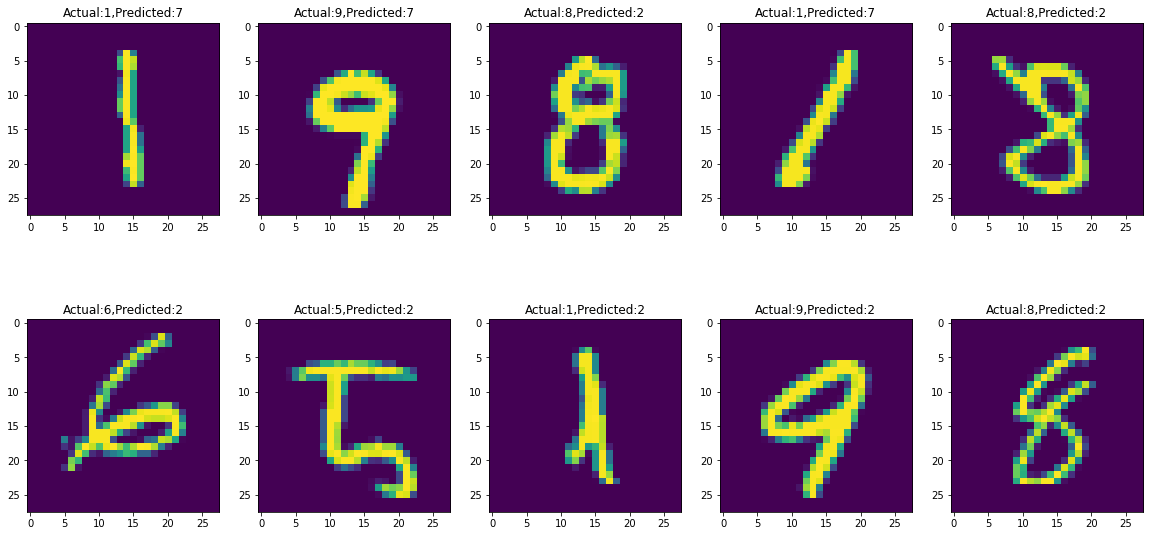



Normalization type:  Layer
EPOCH: 1


Loss=0.10026297718286514 Batch_id=468 Accuracy=86.87: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]



Test set: Average loss: 0.1001, Accuracy: 9753/10000 (97.53%)

EPOCH: 2


Loss=0.019750628620386124 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:18<00:00, 25.36it/s]



Test set: Average loss: 0.0580, Accuracy: 9846/10000 (98.46%)

EPOCH: 3


Loss=0.036896124482154846 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:18<00:00, 25.39it/s]



Test set: Average loss: 0.0459, Accuracy: 9872/10000 (98.72%)

EPOCH: 4


Loss=0.04039803519845009 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]



Test set: Average loss: 0.0399, Accuracy: 9881/10000 (98.81%)

EPOCH: 5


Loss=0.023014379665255547 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:18<00:00, 25.42it/s]



Test set: Average loss: 0.0450, Accuracy: 9868/10000 (98.68%)

EPOCH: 6


Loss=0.06621287018060684 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:18<00:00, 25.55it/s]



Test set: Average loss: 0.0325, Accuracy: 9898/10000 (98.98%)

EPOCH: 7


Loss=0.06401994824409485 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]



Test set: Average loss: 0.0292, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.016212455928325653 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:19<00:00, 24.18it/s]



Test set: Average loss: 0.0292, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.04146981239318848 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:18<00:00, 25.52it/s]



Test set: Average loss: 0.0292, Accuracy: 9907/10000 (99.07%)

EPOCH: 10


Loss=0.05468960478901863 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:18<00:00, 25.49it/s]



Test set: Average loss: 0.0258, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.01758936047554016 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:18<00:00, 25.25it/s]



Test set: Average loss: 0.0300, Accuracy: 9902/10000 (99.02%)

EPOCH: 12


Loss=0.007112367078661919 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:18<00:00, 25.36it/s]



Test set: Average loss: 0.0258, Accuracy: 9907/10000 (99.07%)

EPOCH: 13


Loss=0.045047078281641006 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:18<00:00, 25.41it/s]



Test set: Average loss: 0.0214, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.004383380990475416 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:18<00:00, 25.21it/s]



Test set: Average loss: 0.0238, Accuracy: 9926/10000 (99.26%)

EPOCH: 15


Loss=0.005177340004593134 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:18<00:00, 25.48it/s]



Test set: Average loss: 0.0281, Accuracy: 9910/10000 (99.10%)

EPOCH: 16


Loss=0.0056996275670826435 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:18<00:00, 25.32it/s]



Test set: Average loss: 0.0205, Accuracy: 9930/10000 (99.30%)

EPOCH: 17


Loss=0.014466025866568089 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:19<00:00, 23.57it/s]



Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.017233368009328842 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:18<00:00, 25.36it/s]



Test set: Average loss: 0.0242, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=0.02171333320438862 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:18<00:00, 25.05it/s]



Test set: Average loss: 0.0241, Accuracy: 9922/10000 (99.22%)

EPOCH: 20


Loss=0.004992692265659571 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]



Test set: Average loss: 0.0242, Accuracy: 9921/10000 (99.21%)

Normalization technique:  Layer


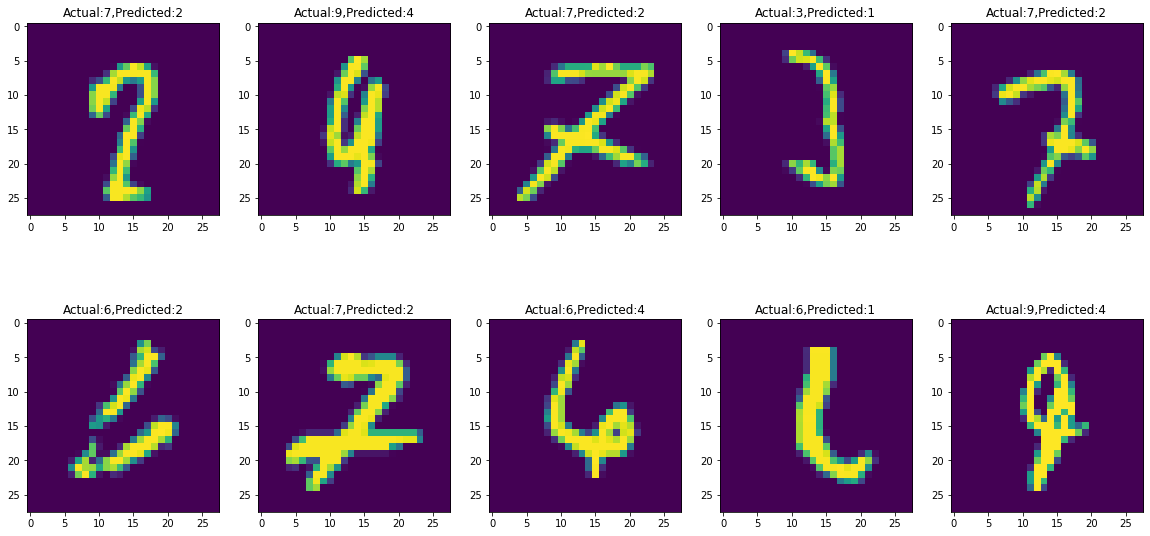



Normalization type:  Group
EPOCH: 1


Loss=0.07380226999521255 Batch_id=468 Accuracy=85.53: 100%|██████████| 469/469 [00:18<00:00, 25.20it/s]



Test set: Average loss: 0.1063, Accuracy: 9737/10000 (97.37%)

EPOCH: 2


Loss=0.07306545227766037 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:18<00:00, 25.45it/s]



Test set: Average loss: 0.0607, Accuracy: 9831/10000 (98.31%)

EPOCH: 3


Loss=0.07524099200963974 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:18<00:00, 25.74it/s]



Test set: Average loss: 0.0442, Accuracy: 9864/10000 (98.64%)

EPOCH: 4


Loss=0.02260497957468033 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:18<00:00, 25.91it/s]



Test set: Average loss: 0.0529, Accuracy: 9837/10000 (98.37%)

EPOCH: 5


Loss=0.046575382351875305 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:19<00:00, 24.41it/s]



Test set: Average loss: 0.0403, Accuracy: 9876/10000 (98.76%)

EPOCH: 6


Loss=0.03530651703476906 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]



Test set: Average loss: 0.0332, Accuracy: 9897/10000 (98.97%)

EPOCH: 7


Loss=0.08406982570886612 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:18<00:00, 25.86it/s]



Test set: Average loss: 0.0314, Accuracy: 9905/10000 (99.05%)

EPOCH: 8


Loss=0.04406818747520447 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:18<00:00, 25.33it/s]



Test set: Average loss: 0.0321, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.013531380333006382 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]



Test set: Average loss: 0.0283, Accuracy: 9915/10000 (99.15%)

EPOCH: 10


Loss=0.059075769037008286 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]



Test set: Average loss: 0.0300, Accuracy: 9908/10000 (99.08%)

EPOCH: 11


Loss=0.038126036524772644 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]



Test set: Average loss: 0.0244, Accuracy: 9925/10000 (99.25%)

EPOCH: 12


Loss=0.008600651286542416 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:18<00:00, 25.70it/s]



Test set: Average loss: 0.0263, Accuracy: 9916/10000 (99.16%)

EPOCH: 13


Loss=0.06334815174341202 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]



Test set: Average loss: 0.0274, Accuracy: 9914/10000 (99.14%)

EPOCH: 14


Loss=0.006594759877771139 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:19<00:00, 24.13it/s]



Test set: Average loss: 0.0292, Accuracy: 9899/10000 (98.99%)

EPOCH: 15


Loss=0.03944743052124977 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:18<00:00, 25.48it/s]



Test set: Average loss: 0.0247, Accuracy: 9919/10000 (99.19%)

EPOCH: 16


Loss=0.028980694711208344 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:18<00:00, 25.25it/s]



Test set: Average loss: 0.0248, Accuracy: 9913/10000 (99.13%)

EPOCH: 17


Loss=0.006245389115065336 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]



Test set: Average loss: 0.0243, Accuracy: 9923/10000 (99.23%)

EPOCH: 18


Loss=0.006835118401795626 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:18<00:00, 25.52it/s]



Test set: Average loss: 0.0249, Accuracy: 9918/10000 (99.18%)

EPOCH: 19


Loss=0.029523132368922234 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:18<00:00, 25.25it/s]



Test set: Average loss: 0.0266, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.08177947998046875 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:18<00:00, 25.56it/s]



Test set: Average loss: 0.0239, Accuracy: 9929/10000 (99.29%)

Normalization technique:  Group


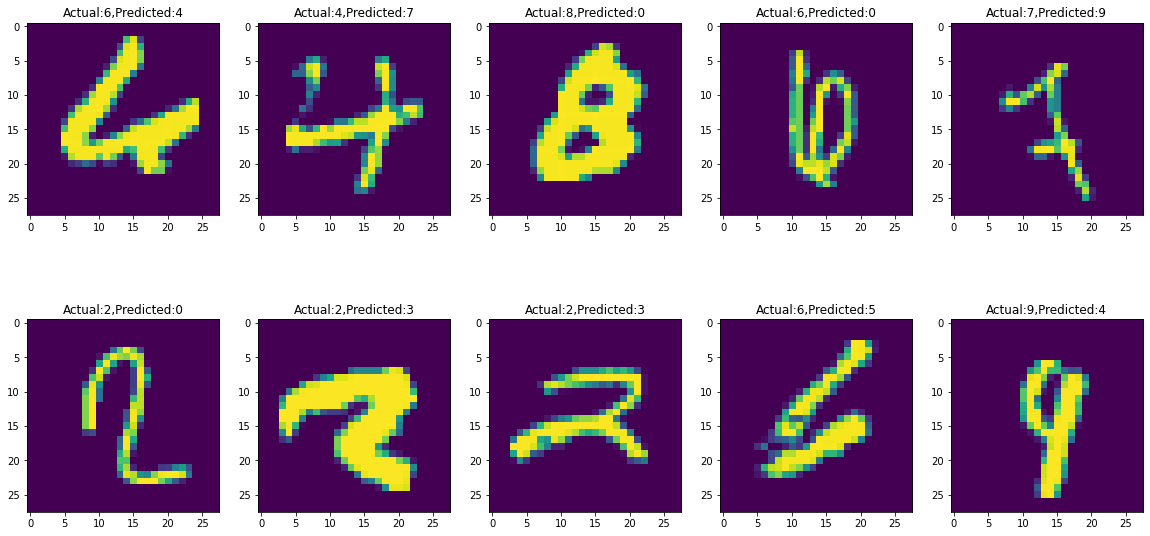

In [11]:
normalization_iter = ["Batch", "Layer", "Group"]
num_of_groups_iter = [0, 0, 4]
lambda_val = [0.01, 0, 0]

train_losses_all=[]
train_acc_all=[]
test_losses_all=[]
test_acc_all=[]

for (norm, no_gps, l_val) in zip(normalization_iter, num_of_groups_iter, lambda_val):
  print ("Normalization type: ", norm)
  model =  Net(normalization_type=norm, group_num = no_gps).to(device) 
  train_losses, train_acc, test_losses, test_acc = run_model(model, device, train_loader, test_loader, l_val)
  train_losses_all.append(train_losses)
  train_acc_all.append(train_acc)
  test_losses_all.append(test_losses)
  test_acc_all.append(test_acc)
  true,pred,image,true_wrong,pred_wrong = test_missclassified(test_loader)
  wrong_plot(10,true_wrong,image,pred_wrong, norm)
  print ("\n\n")

### Plotting

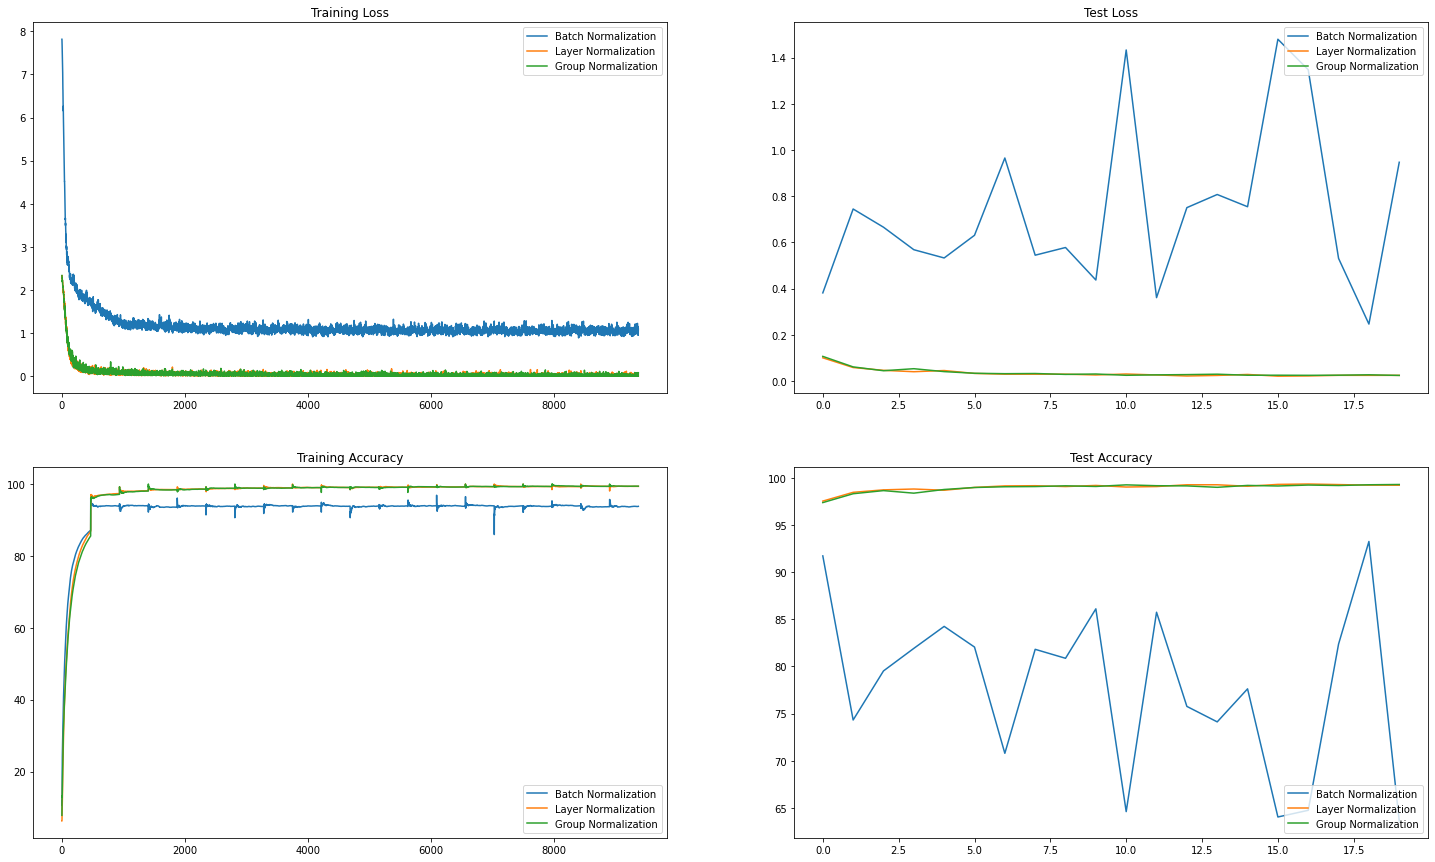

In [12]:
fig, axs = plt.subplots(2,2,figsize=(25,15))
for i, norm_type in enumerate(normalization_iter):

      axs[0, 0].set_title("Training Loss")
      axs[1, 0].set_title("Training Accuracy")
      axs[0, 1].set_title("Test Loss")
      axs[1, 1].set_title("Test Accuracy")

      axs[0, 0].plot(train_losses_all[i], label = norm_type + " Normalization")
      axs[0,0].legend(loc='upper right')
  

      axs[1, 0].plot(train_acc_all[i], label = norm_type + " Normalization")
      axs[1,0].legend(loc='lower right')


      axs[0, 1].plot(test_losses_all[i], label = norm_type + " Normalization")
      axs[0,1].legend(loc='upper right')


      axs[1, 1].plot(test_acc_all[i], label = norm_type + " Normalization")
      axs[1,1].legend(loc='lower right')